## In this notebook, we use Care for pair wise training. Q3.
## CM02: Q0_o, Q1_o, Q2_o, Q3_o, Q4_o, Q4_i, Q3_i, Q2_i, Q1_i, Q0_i
## CM03: Q0_i, Q1_i, Q2_i, Q3_i, Q4_i, Q4_o, Q3_o, Q2_o, Q1_o, Q0_o

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE
import glob
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
import copy


Using TensorFlow backend.


## Load Input and Output Data (jug-pc-1)

In [2]:
filenames = glob.glob("/home/lalit/Desktop/02_Datasets/KellerLab/Data/CM02_flipped/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print(len(imgs))
print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

10
Typical shape: (70, 896, 576)
Typical datatype: float64


## Take only the -28:-21  z-slices as input from CM02

In [3]:
X_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][-28:-21, ...]
    X_CM02.append(temp)
print(X_CM02[5].shape)

(7, 896, 576)


## Take only the 21:28 z-slices as output from CM02

In [4]:
Y_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][21:28, ...]
    Y_CM02.append(temp)
print(Y_CM02[5].shape)

(7, 896, 576)


## Load images from CM03 (jug-pc-1)

In [5]:
filenames = glob.glob("/home/lalit/Desktop/02_Datasets/KellerLab/Data/CM03/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

Typical shape: (70, 896, 576)
Typical datatype: float64


## Take only the 21:28 z-slices from CM03 as input

In [6]:
X_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][21:28, ...]
    X_CM03.append(temp)
print(X_CM03[5].shape)

(7, 896, 576)


## Take only the -28:-21 z-slices from CM03 as output

In [7]:
Y_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][-28:-21, ...]
    Y_CM03.append(temp)
print(Y_CM03[5].shape)

(7, 896, 576)


## Combine X_CM02 and X_CM03

In [8]:
imgsX=X_CM02+X_CM03
print(len(imgsX))
print(imgsX[5].shape)

20
(7, 896, 576)


In [9]:
imgsY=Y_CM03+Y_CM02
print(len(imgsY))
print(imgsY[5].shape)

20
(7, 896, 576)


## Visualize the images 

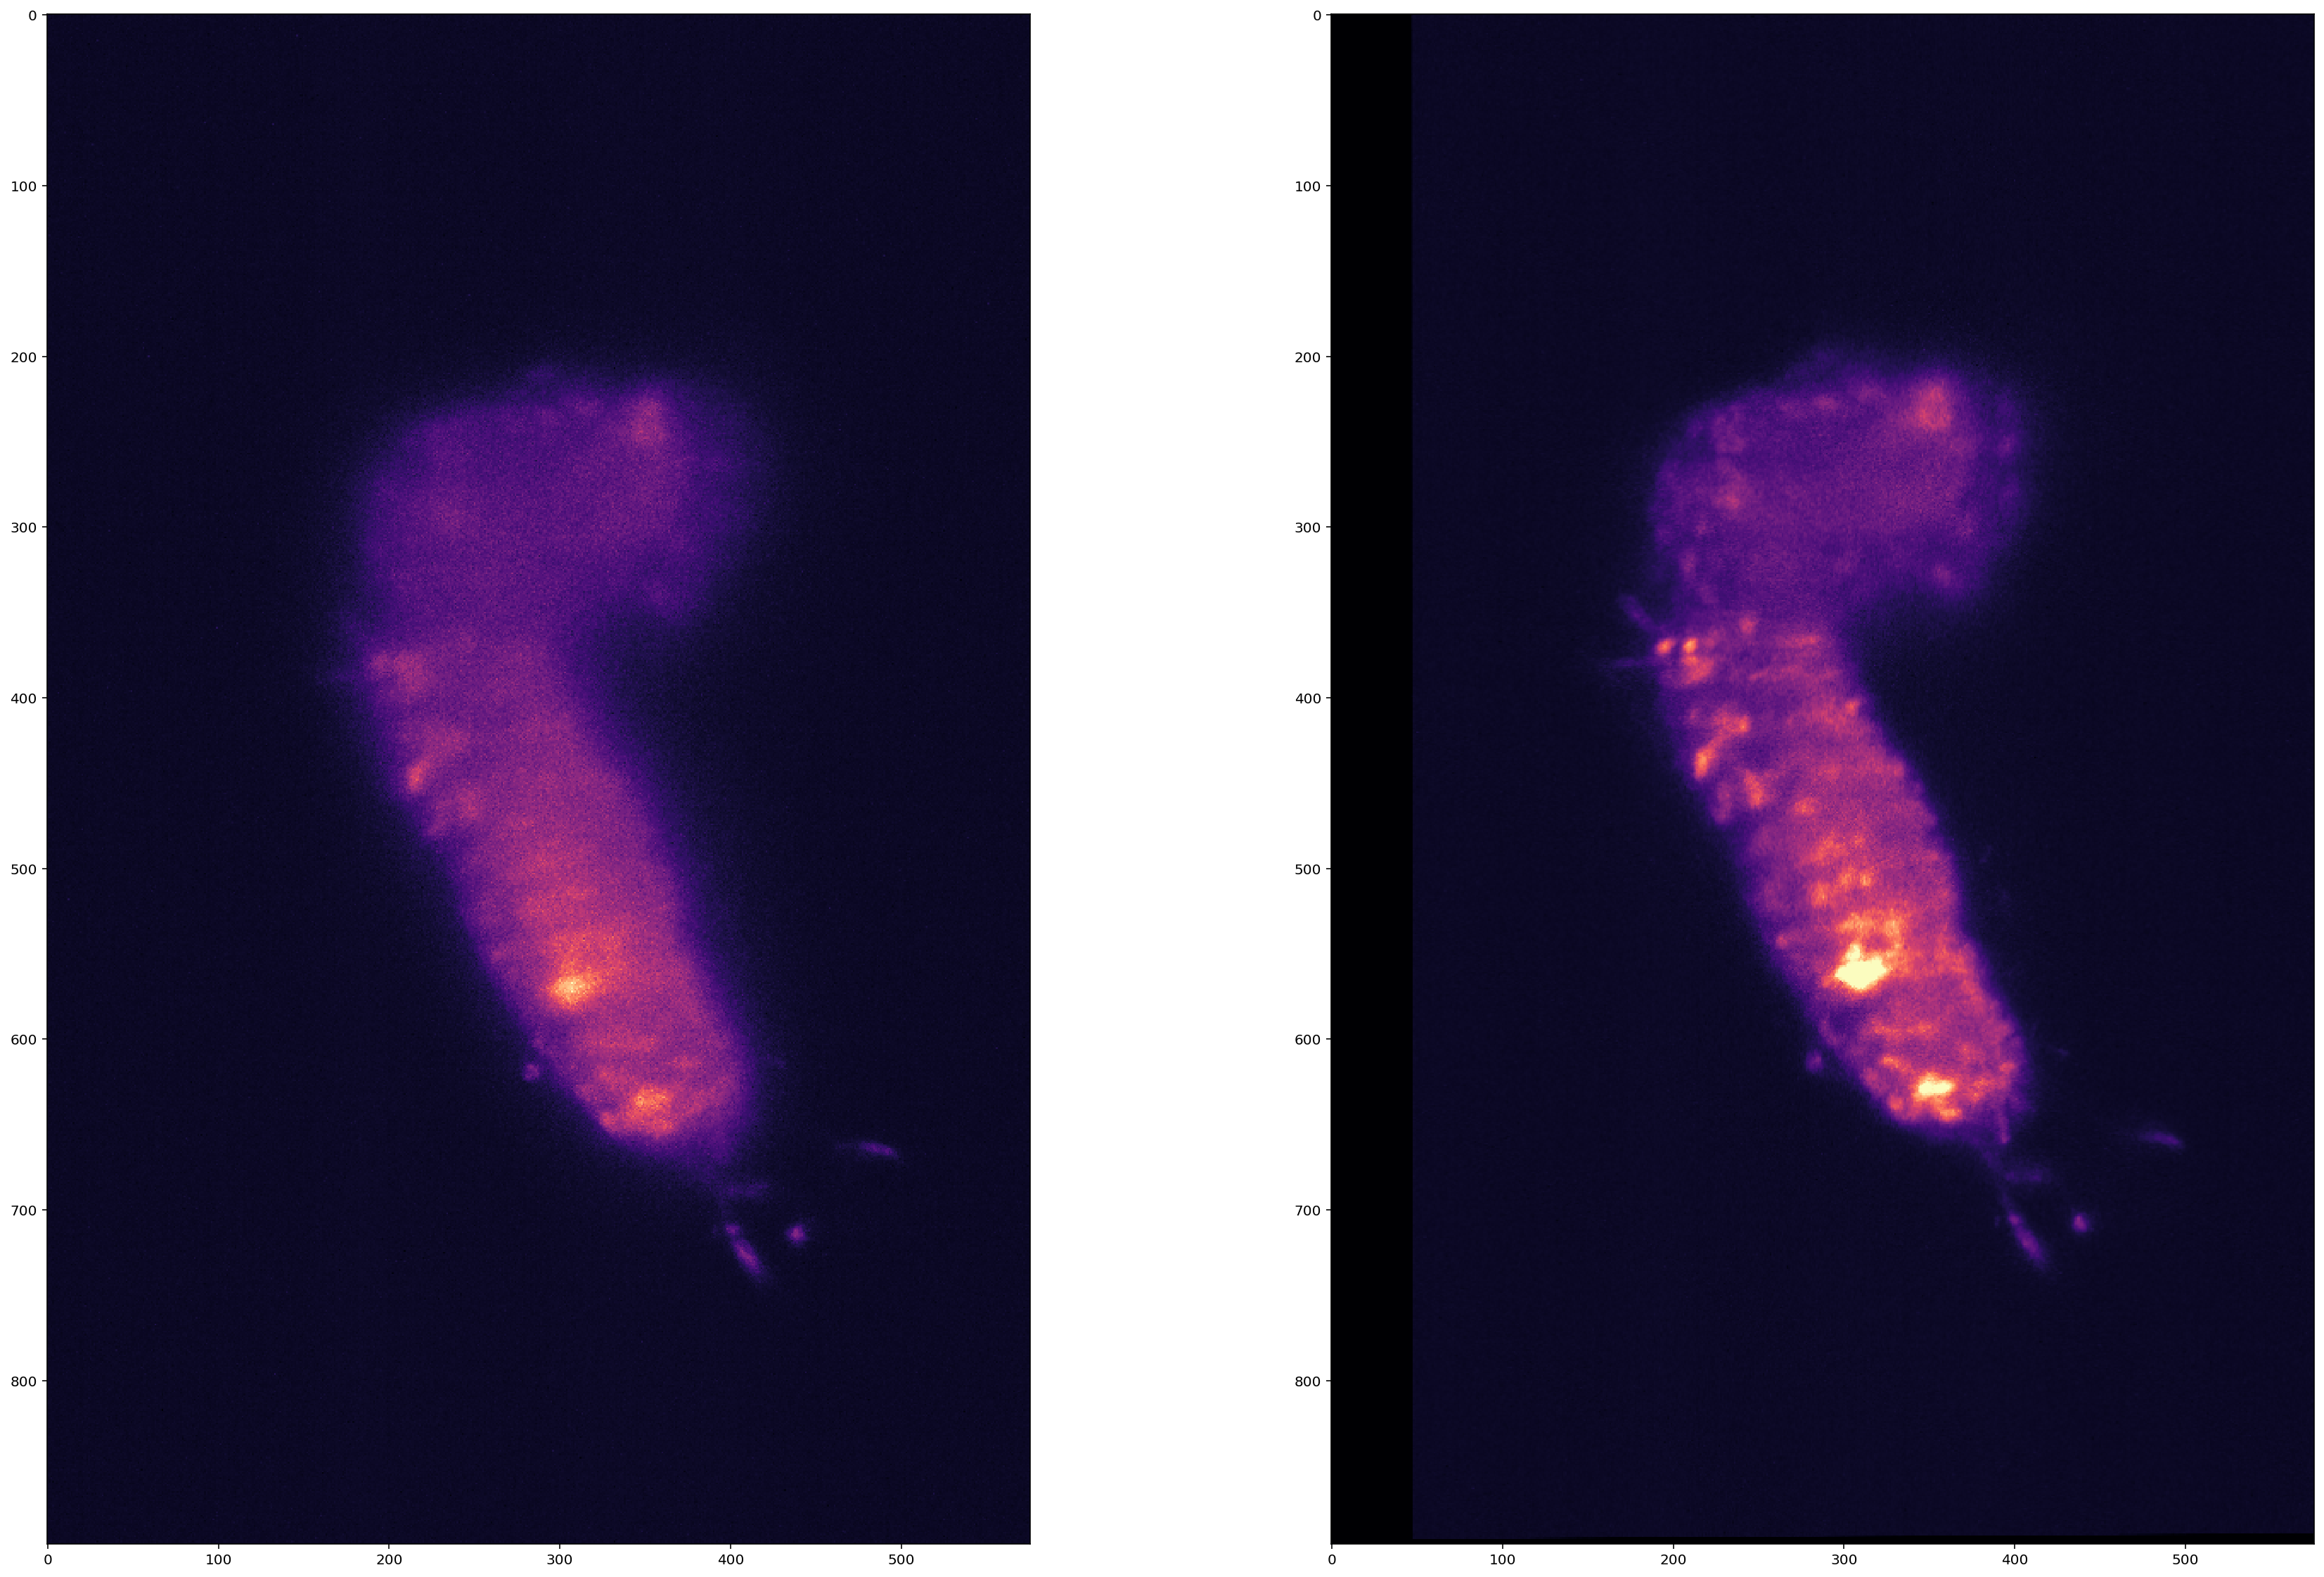

In [10]:
vmin=np.min(imgsX[14][5,...])
vmax=np.max(imgsX[14][5,...])
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgsX[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(imgsY[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.show()

## Since there is an artificial margin in the input and the output, we chop away the first and last 60 in the x dimension and in the y dimension

In [11]:
imgsX_chopped=[]
imgsY_chopped=[]
for i in range(len(imgsX)):
    imgsX_chopped.append(imgsX[i][:, 60:-60, 60:-60])
    imgsY_chopped.append(imgsY[i][:, 60:-60, 60:-60])

## Visualize the images again

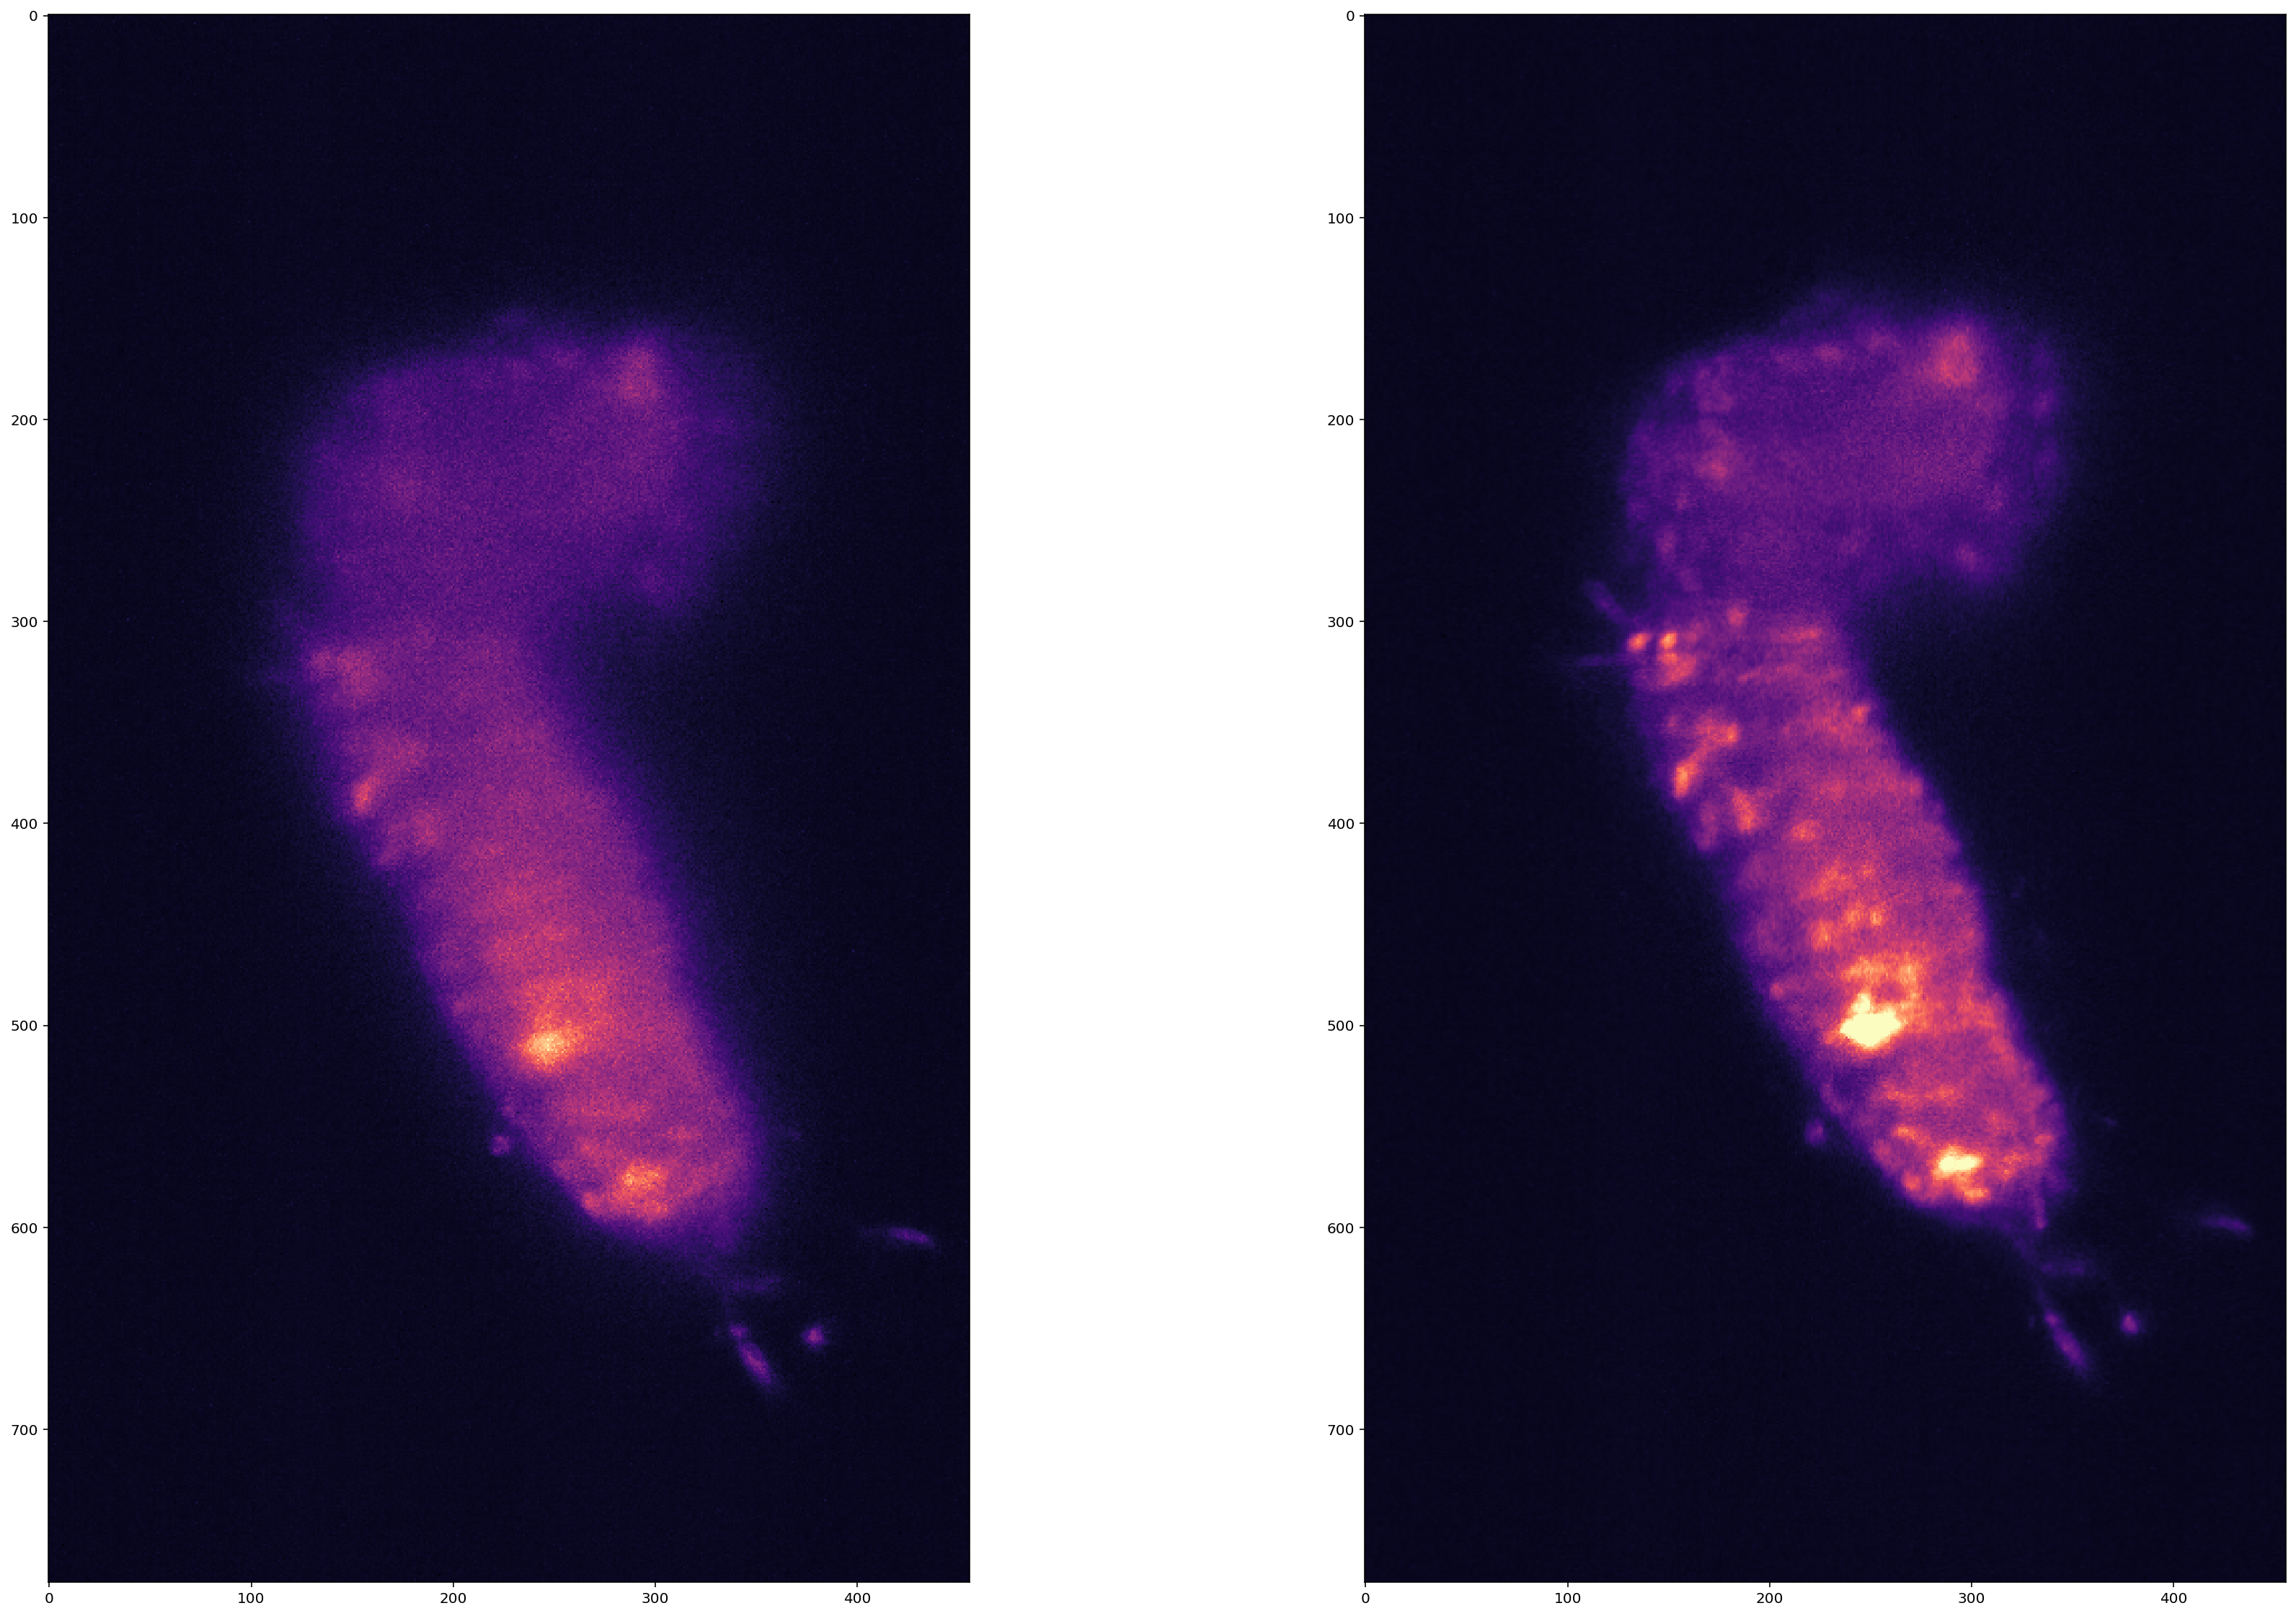

In [12]:
vmin=np.min(imgsX_chopped[15][5,...])
vmax=np.max(imgsX_chopped[15][5,...])
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgsX_chopped[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(imgsY_chopped[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.show()

## Also we must normalize the patches, prior to training !!

In [13]:
mean=np.mean(imgsX_chopped)
print(mean)
std=np.std(imgsX_chopped)
print(std)

130.72475878000412
56.8538577709521


## Create patches

In [14]:
imgsX_chopped=np.concatenate(imgsX_chopped, axis=0)
print(imgsX_chopped.shape)
imgsY_chopped=np.concatenate(imgsY_chopped, axis=0)
print(imgsY_chopped.shape)

(140, 776, 456)
(140, 776, 456)


In [15]:
combined=np.empty([np.shape(imgsX_chopped)[0], np.shape(imgsX_chopped)[1], np.shape(imgsX_chopped)[2], 2])
combined[..., 0]=imgsX_chopped
combined[..., 1]=imgsY_chopped
# Normalization Step
combined=(combined-mean)/std
print(combined.dtype)

float64


In [16]:
combinedList=[]
combinedList.append(combined)
print(len(combinedList))

1


## Augment is set to True

In [17]:
datagen = N2V_DataGenerator()
patches = datagen.generate_patches_from_list(combinedList, shape=(96, 96), augment=True)
print(patches.shape)

Generated patches: (35840, 96, 96, 2)
(35840, 96, 96, 2)


## Create train and validation pairs

In [18]:
X=patches[:-1000,..., 0]
X=X[..., np.newaxis]
Y=patches[:-1000, ..., 1]
Y=Y[..., np.newaxis]
X_val=patches[-1000:,..., 0]
X_val=X_val[..., np.newaxis]
Y_val=patches[-1000:, ..., 1]
Y_val=Y_val[..., np.newaxis]
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)
print("X_val shape: ", X_val.shape)
print("Y_val shape: ", Y_val.shape)

X shape:  (34840, 96, 96, 1)
Y shape:  (34840, 96, 96, 1)
X_val shape:  (1000, 96, 96, 1)
Y_val shape:  (1000, 96, 96, 1)


In [19]:
print("Datatype is:", patches[0, ..., 0].dtype)

Datatype is: float64


## Plot some examples from validation data

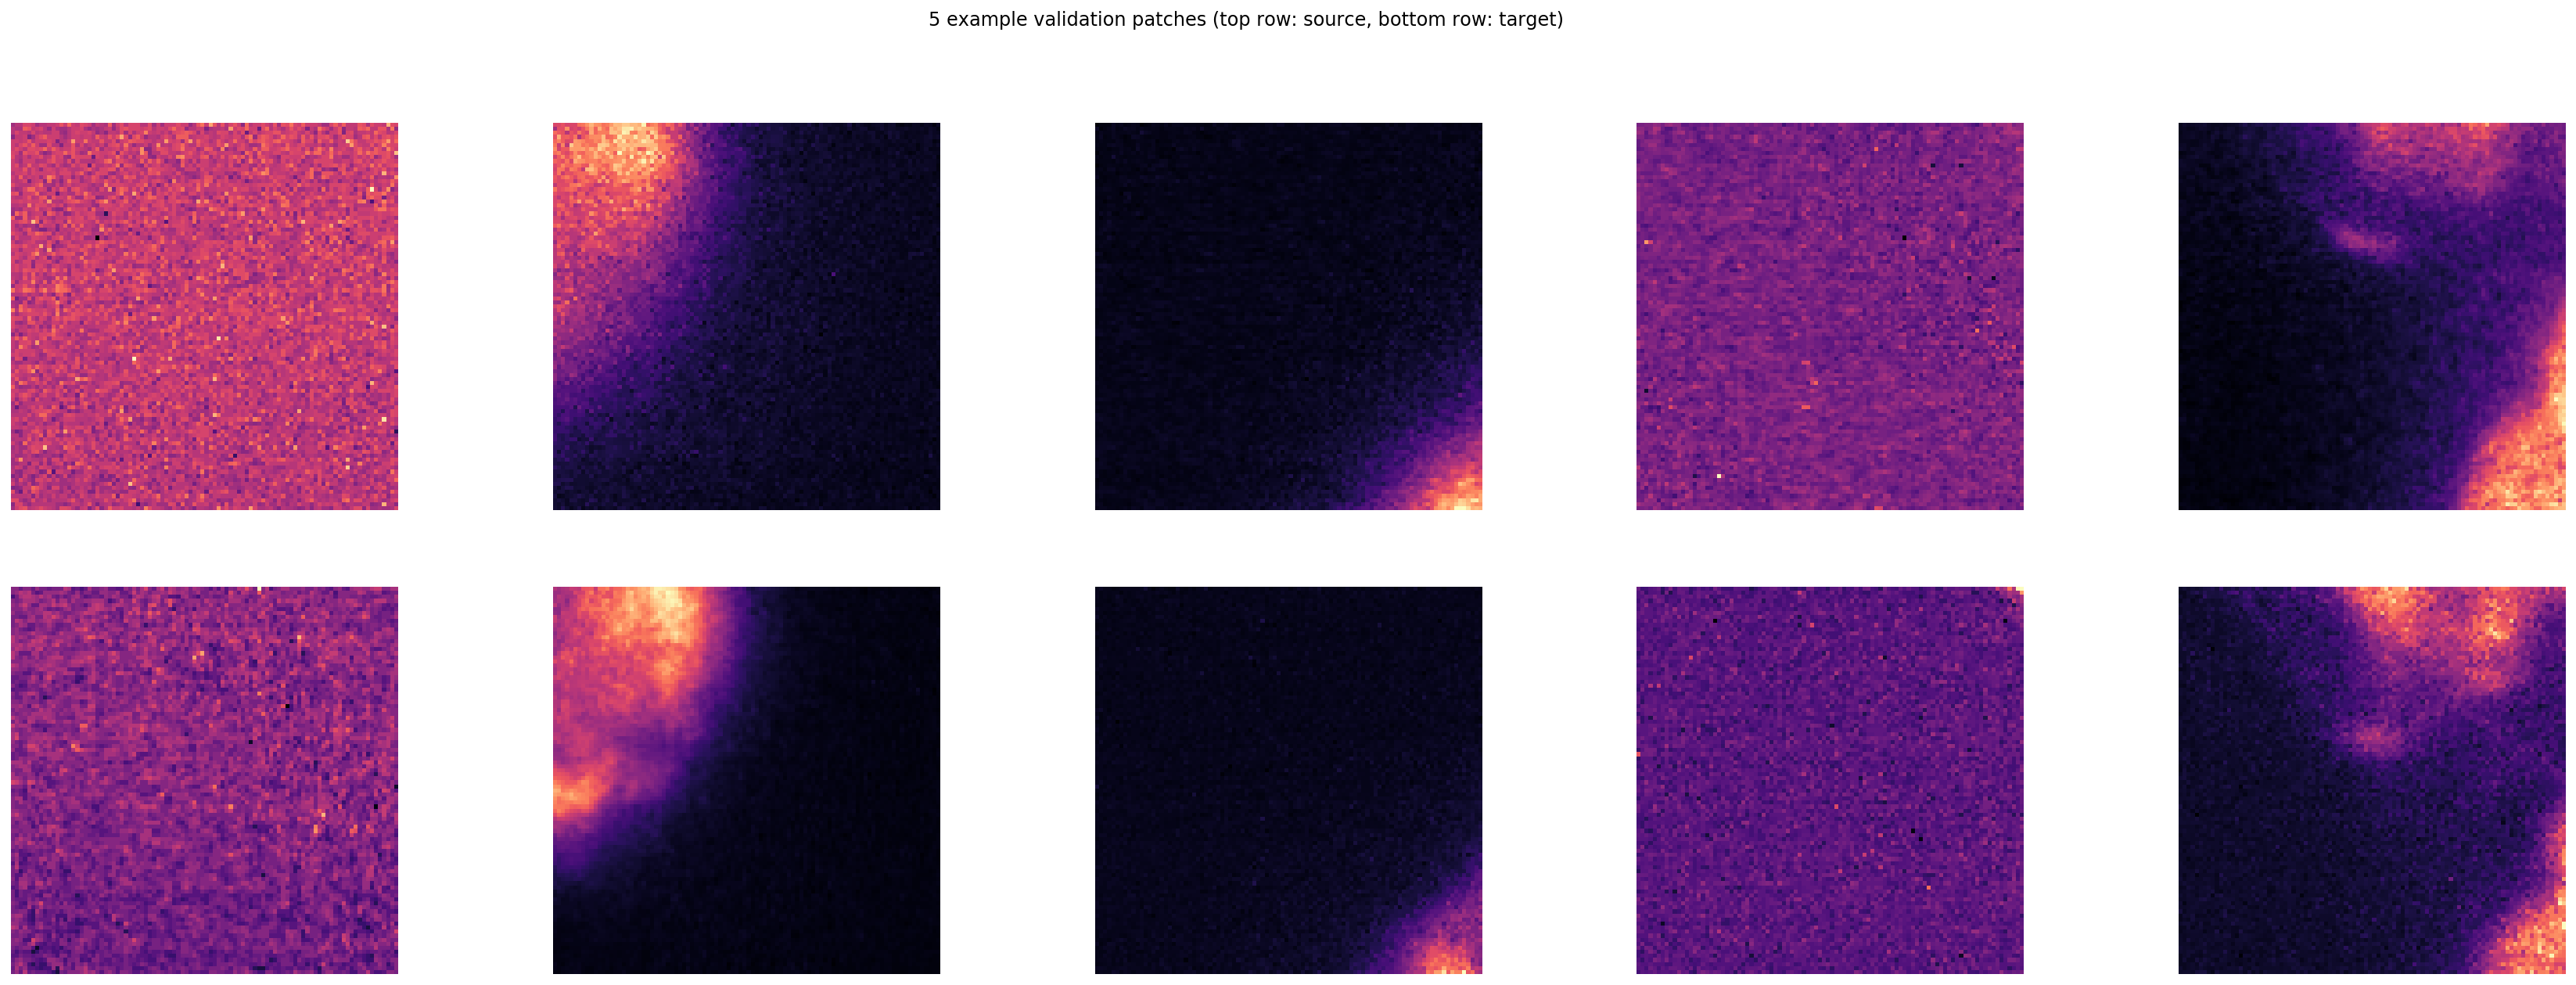

In [20]:
plt.figure(figsize=(30,10))
plot_some(X_val[300:305, ...],Y_val[300:305, ...])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [21]:
axes='SYXC'
n_channel_in=1
n_channel_out=1
config = Config(axes, n_channel_in, n_channel_out, probabilistic=False, train_steps_per_epoch=250, train_epochs=300, unet_n_first=64, unet_n_depth=3, unet_residual=False)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=300, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=250, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=3, unet_n_first=64, unet_residual=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 5,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 300,
 'train_steps_per_epoch': 250,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [22]:
model = CARE(config, 'care_2D_kellerlab_with_normalization_with_HandRegistration_float64_Q3_ne_300_es_250', basedir='models')

In [23]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

/home/lalit/Desktop/01_Softwares/anaconda3/envs/n2v368V2/lib/python3.6/site-packages/csbdeep/models/care_standard.py:259: UserWarning: small number of validation images (only 2.8% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100*frac_val))


Epoch 1/300
250/250 [==============================] - 25s 101ms/step - loss: 0.2269 - mse: 0.3439 - mae: 0.2269 - val_loss: 0.2040 - val_mse: 0.2968 - val_mae: 0.2040
Epoch 2/300
250/250 [==============================] - 24s 95ms/step - loss: 0.2122 - mse: 0.3215 - mae: 0.2122 - val_loss: 0.2138 - val_mse: 0.3045 - val_mae: 0.2138
Epoch 3/300
250/250 [==============================] - 24s 95ms/step - loss: 0.2073 - mse: 0.3013 - mae: 0.2073 - val_loss: 0.2023 - val_mse: 0.2854 - val_mae: 0.2023
Epoch 4/300
250/250 [==============================] - 24s 95ms/step - loss: 0.2168 - mse: 0.3045 - mae: 0.2168 - val_loss: 0.1991 - val_mse: 0.2814 - val_mae: 0.1991
Epoch 5/300
250/250 [==============================] - 24s 94ms/step - loss: 0.2093 - mse: 0.2940 - mae: 0.2093 - val_loss: 0.1997 - val_mse: 0.2899 - val_mae: 0.1997
Epoch 6/300
250/250 [==============================] - 24s 96ms/step - loss: 0.2026 - mse: 0.2797 - mae: 0.2026 - val_loss: 0.1985 - val_mse: 0.2787 - val_mae: 0.19

250/250 [==============================] - 23s 94ms/step - loss: 0.1914 - mse: 0.2735 - mae: 0.1914 - val_loss: 0.1848 - val_mse: 0.2566 - val_mae: 0.1848
Epoch 50/300
250/250 [==============================] - 24s 95ms/step - loss: 0.1930 - mse: 0.2888 - mae: 0.1930 - val_loss: 0.1838 - val_mse: 0.2507 - val_mae: 0.1838
Epoch 51/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1898 - mse: 0.2640 - mae: 0.1898 - val_loss: 0.1844 - val_mse: 0.2612 - val_mae: 0.1844
Epoch 52/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1948 - mse: 0.2862 - mae: 0.1948 - val_loss: 0.1879 - val_mse: 0.2778 - val_mae: 0.1879
Epoch 53/300
250/250 [==============================] - 24s 95ms/step - loss: 0.1850 - mse: 0.2569 - mae: 0.1850 - val_loss: 0.1836 - val_mse: 0.2556 - val_mae: 0.1836
Epoch 54/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1852 - mse: 0.2618 - mae: 0.1852 - val_loss: 0.1858 - val_mse: 0.2442 - val_mae: 0.1858
Epoch

250/250 [==============================] - 24s 94ms/step - loss: 0.1882 - mse: 0.2575 - mae: 0.1882 - val_loss: 0.1780 - val_mse: 0.2285 - val_mae: 0.1780
Epoch 98/300
250/250 [==============================] - 24s 95ms/step - loss: 0.1838 - mse: 0.2545 - mae: 0.1838 - val_loss: 0.1787 - val_mse: 0.2296 - val_mae: 0.1787
Epoch 99/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1841 - mse: 0.2557 - mae: 0.1841 - val_loss: 0.1788 - val_mse: 0.2368 - val_mae: 0.1788
Epoch 100/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1830 - mse: 0.2532 - mae: 0.1830 - val_loss: 0.1799 - val_mse: 0.2207 - val_mae: 0.1799
Epoch 101/300
250/250 [==============================] - 24s 95ms/step - loss: 0.1889 - mse: 0.2646 - mae: 0.1889 - val_loss: 0.1787 - val_mse: 0.2219 - val_mae: 0.1787
Epoch 102/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1816 - mse: 0.2377 - mae: 0.1816 - val_loss: 0.1782 - val_mse: 0.2252 - val_mae: 0.1782
Ep

250/250 [==============================] - 23s 94ms/step - loss: 0.1815 - mse: 0.2397 - mae: 0.1815 - val_loss: 0.1756 - val_mse: 0.2216 - val_mae: 0.1756
Epoch 145/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1846 - mse: 0.2423 - mae: 0.1846 - val_loss: 0.1756 - val_mse: 0.2215 - val_mae: 0.1756
Epoch 146/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1839 - mse: 0.2348 - mae: 0.1839 - val_loss: 0.1756 - val_mse: 0.2169 - val_mae: 0.1756
Epoch 147/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1783 - mse: 0.2178 - mae: 0.1783 - val_loss: 0.1756 - val_mse: 0.2166 - val_mae: 0.1756
Epoch 148/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1766 - mse: 0.2247 - mae: 0.1766 - val_loss: 0.1757 - val_mse: 0.2162 - val_mae: 0.1757
Epoch 149/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1764 - mse: 0.2248 - mae: 0.1764 - val_loss: 0.1757 - val_mse: 0.2158 - val_mae: 0.1757


250/250 [==============================] - 23s 94ms/step - loss: 0.1819 - mse: 0.2354 - mae: 0.1819 - val_loss: 0.1752 - val_mse: 0.2118 - val_mae: 0.1752
Epoch 193/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1787 - mse: 0.2235 - mae: 0.1787 - val_loss: 0.1748 - val_mse: 0.2161 - val_mae: 0.1748
Epoch 194/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1723 - mse: 0.2074 - mae: 0.1723 - val_loss: 0.1747 - val_mse: 0.2151 - val_mae: 0.1747
Epoch 195/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1797 - mse: 0.2229 - mae: 0.1797 - val_loss: 0.1750 - val_mse: 0.2216 - val_mae: 0.1750
Epoch 196/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1791 - mse: 0.2319 - mae: 0.1791 - val_loss: 0.1757 - val_mse: 0.2113 - val_mae: 0.1757
Epoch 197/300
250/250 [==============================] - 25s 98ms/step - loss: 0.1873 - mse: 0.2508 - mae: 0.1873 - val_loss: 0.1750 - val_mse: 0.2209 - val_mae: 0.1750


250/250 [==============================] - 23s 94ms/step - loss: 0.1809 - mse: 0.2197 - mae: 0.1809 - val_loss: 0.1741 - val_mse: 0.2150 - val_mae: 0.1741
Epoch 241/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1774 - mse: 0.2280 - mae: 0.1774 - val_loss: 0.1748 - val_mse: 0.2120 - val_mae: 0.1748
Epoch 242/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1815 - mse: 0.2316 - mae: 0.1815 - val_loss: 0.1746 - val_mse: 0.2202 - val_mae: 0.1746
Epoch 243/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1800 - mse: 0.2351 - mae: 0.1800 - val_loss: 0.1747 - val_mse: 0.2081 - val_mae: 0.1747
Epoch 244/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1796 - mse: 0.2357 - mae: 0.1796 - val_loss: 0.1746 - val_mse: 0.2184 - val_mae: 0.1746
Epoch 245/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1823 - mse: 0.2355 - mae: 0.1823 - val_loss: 0.1766 - val_mse: 0.2101 - val_mae: 0.1766


250/250 [==============================] - 23s 94ms/step - loss: 0.1792 - mse: 0.2145 - mae: 0.1792 - val_loss: 0.1735 - val_mse: 0.2104 - val_mae: 0.1735
Epoch 288/300
250/250 [==============================] - 23s 93ms/step - loss: 0.1852 - mse: 0.2384 - mae: 0.1852 - val_loss: 0.1735 - val_mse: 0.2109 - val_mae: 0.1735
Epoch 289/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1766 - mse: 0.2314 - mae: 0.1766 - val_loss: 0.1735 - val_mse: 0.2094 - val_mae: 0.1735
Epoch 290/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1811 - mse: 0.2264 - mae: 0.1811 - val_loss: 0.1736 - val_mse: 0.2105 - val_mae: 0.1736
Epoch 291/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1711 - mse: 0.2063 - mae: 0.1711 - val_loss: 0.1736 - val_mse: 0.2090 - val_mae: 0.1736
Epoch 292/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1826 - mse: 0.2445 - mae: 0.1826 - val_loss: 0.1738 - val_mse: 0.2089 - val_mae: 0.1738


['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


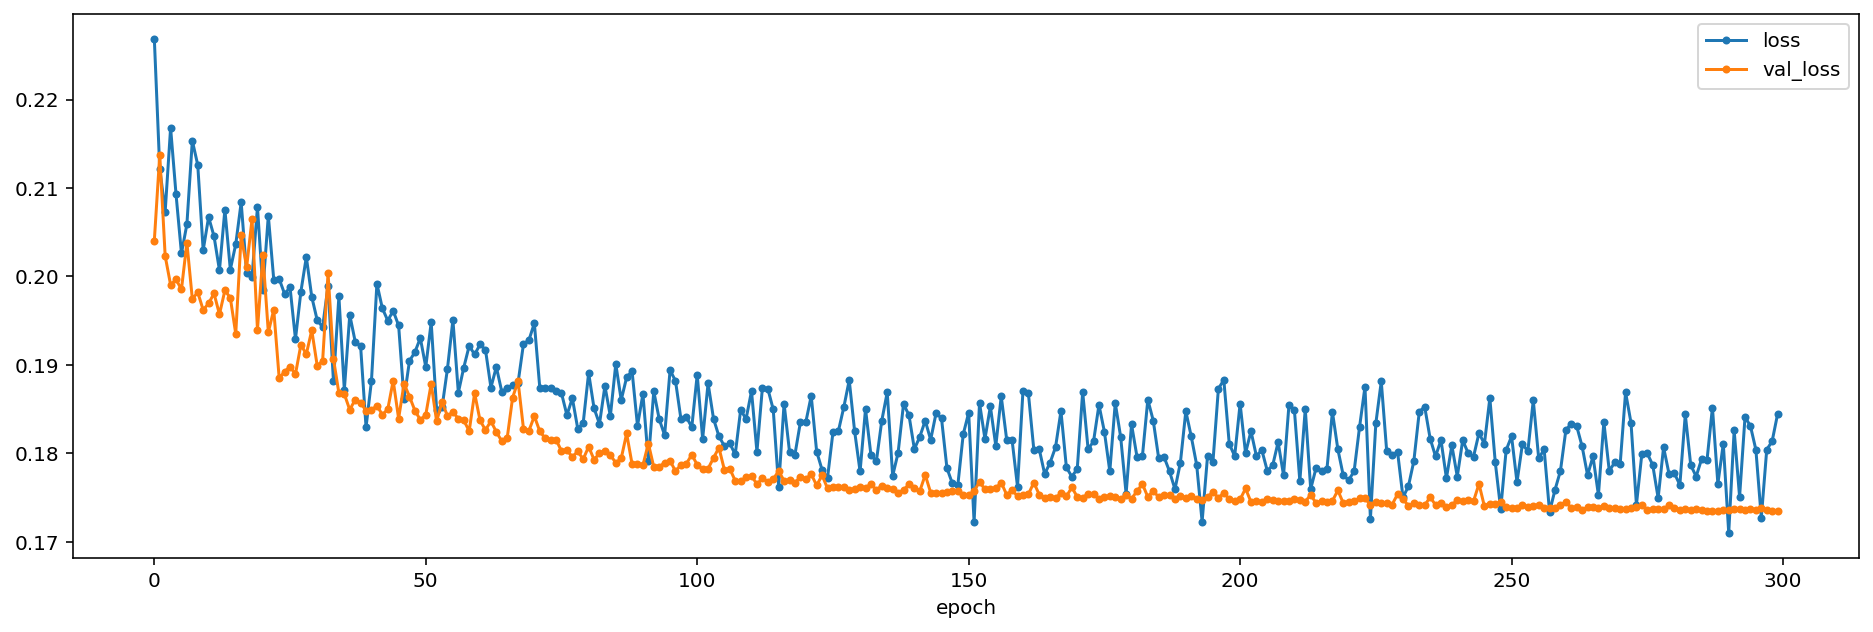

In [24]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);